# Approach 3: MAB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm

In [2]:
# Fixate the global random seed
SEED = 0
np.random.seed(SEED)

## Training

###  Data Preprocessing
Load the default-preprocessed training dataset: 

In [3]:
TRAIN_PATH = 'data/train.csv'

df_train = pd.read_csv(TRAIN_PATH)

In [4]:
print(f"> Size of train df: %d" % len(df_train["rating"]))
print("> Quick visual check of dataframe:") 
df_train.head()

> Size of train df: 90570
> Quick visual check of dataframe:


,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime


MAB specific restriction: only the movies (item_id) with 200 rating or more:


In [5]:
df_train_counts = df_train['item_id'].value_counts()
df_train_counts = df_train_counts[df_train_counts >= 200]

df_200_mask = df_train['item_id'].isin(df_train_counts.index)

df_train = df_train[df_200_mask]

In [6]:
print("> Check that now only items with >= 200 ratings in the training dataframe:")
print(f"> Min amounts of ratings per item present is %d." % min(df_train['item_id'].value_counts()))


> Check that now only items with >= 200 ratings in the training dataframe:
> Min amounts of ratings per item present is 200.


Split the training data into the four focal groups. We run the MAB on each one of them.


In [7]:
mask_young = df_train['user_age'] < 30
mask_male = df_train['user_gender'] == "M"



df_user_my = df_train[mask_male & mask_young]
df_user_mo = df_train[mask_male & ~mask_young]
df_user_fy = df_train[~mask_male & mask_young]
df_user_fo = df_train[~mask_male & ~mask_young]

df_user_groups = {
    'my' : df_user_my,
    'mo' : df_user_mo,
    'fy' : df_user_fy,
    'fo' : df_user_fo
}


In [8]:
df_user_groups['my']

,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
6,1,7,4,24,M,technician,Arizona,1995.0,Drama
8,1,9,5,24,M,technician,Arizona,1995.0,Drama
10,1,11,2,24,M,technician,Arizona,1995.0,Crime
11,1,12,5,24,M,technician,Arizona,1995.0,Crime
...,...,...,...,...,...,...,...,...,...
90510,943,423,3,22,M,student,Texas,1982.0,Children's
90520,943,475,5,22,M,student,Texas,1996.0,Drama
90525,943,546,4,22,M,student,Texas,1996.0,Action
90529,943,568,3,22,M,student,Texas,1994.0,Action


In [9]:
# TODO generalise to all four groups. For development purposes we start by restricting ourselves to only the `my` dataframe.

In [10]:
df = df_user_my.copy(deep=True)

Get rid of the unneccesary data. This includes the user and movie attributes that are not their ids or the rating. This, because we only care about the information: which user (user_id) likes (rating >= 4) which movie (item_id).

In [11]:
df.drop(
    columns=['user_age','user_gender','user_occupation','user_zip','release_date','genre'], inplace=True
    )
print("Dataframe: `my`")
print(df)

Dataframe: `my`
       user_id  item_id  rating
0            1        1       5
6            1        7       4
8            1        9       5
10           1       11       2
11           1       12       5
...        ...      ...     ...
90510      943      423       3
90520      943      475       5
90525      943      546       4
90529      943      568       3
90538      943      655       4

[9143 rows x 3 columns]


Convert the rating column into a "liked" column:

In [12]:
df['liked'] = df['rating'] >= 4 
df.drop(
    columns=['rating'], 
    inplace=True
    )

In [13]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9143 entries, 0 to 90538
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  9143 non-null   int64
 1   item_id  9143 non-null   int64
 2   liked    9143 non-null   bool 
dtypes: bool(1), int64(2)
memory usage: 223.2 KB


#### Define MAB Structure

Modyfing the MAB replay trainer implemented in the tutorial from week 6:

In [14]:
# _tuple_tries = None
# _item_hit_counter = None

class MAB_replayer(object):
    """ Assumptions 
        -   the reward database is freshly reindexed (i.e. discrete 0,1,.. without jumps)
            => used when indexing into the user/item column
            
    """
    
    
    
    def __init__(self, epsilon, 
                 reward_database, 
                 n_recommendations,
                 item_col_name="item_id", user_col_name = "user_id", reward_col_name = "liked",
                 n_iterations = 1):
        
        print("> Starting MAB machine.")
        ''' Save arguments to object-instance '''
        self.epsilon = epsilon  # greediness
        self.reward_database = reward_database  # used to access the ratings
        self.item_col_name = item_col_name  # header name of item column in that db
        self.user_col_name = user_col_name  # header name of user column in that db
        self.reward_col_name = reward_col_name
        self.n_recommendations = n_recommendations  # number of recs for training the MAB machine
        self.n_iterations = n_iterations  # number of iterations performed subsequently to reduce variance; investigate statistical differences # TODO [analyse, investigate]
        
        ''' Setup subviews of interest '''
        self.items = self.reward_database[self.item_col_name].unique()
        self.items.sort()
        self.n_items = len(self.items)
        
        self.users = self.reward_database[self.user_col_name].unique()
        self.n_users = len(self.users)
        
        
        print(">> Initialized.")
    
    def reset(self):
        ''' (Re-)Initialise the learnt data for next iteration '''
        self.item_counter_arr = np.zeros(self.n_items)  # count how often each item appeared
        self.item_reward_arr = np.zeros(self.n_items)  # accumulated reward per item (in [0,1] range)
        
        print(">>> Reset.")
    
    
    def random_user(self):
        """ returns a user_id for a random user in the the user column of the review_database """
        user_idx = np.random.randint(self.n_users)
        user_id = self.users[user_idx]
        return user_id
    
    def select_item(self):
        """ selects an item from the database with epsilon-greedy strategy """
        
        outcome = np.random.uniform(low=0.0, high=1.0)
        exploring = ( outcome < self.epsilon ) or \
            np.max(self.item_reward_arr == 0) # then we don't want to get the [0] index from iLoc but a random one  
        
        if exploring:
            """ Explore """
            item_idx = np.random.randint(self.n_items)
        else:
            """ Exploit """
            item_idx = np.argmax(self.item_reward_arr)  # DONE check that indeed idx and not an id. would assume idx because array index need not correspond to e.g. the movie id.


        return (item_idx, exploring)
    
        
    def replay(self):
        
        log = []  # store the results from each iteration
        _tuple_tries = np.zeros(self.n_recommendations)
        _item_hit_counter = np.zeros(self.n_items)
        
        print(">> Starting replay.")
        
        for iteration in range(0, self.n_iterations):
            ''' initialise '''
            print(">>> Iteration", iteration)
            self.reset()
            
            total_rewards = 0
            like_fraction = np.zeros(self.n_recommendations)
            
            for rec_idx in tqdm(range(0, self.n_recommendations)):
                found_train_tuple = False
                
                while not found_train_tuple:
                    _tuple_tries[rec_idx] += 1
                    
                    user_id = self.random_user()
                    item_idx, exploring = self.select_item()
                    item_id = self.items[item_idx]

                    # print(f"> User_id: %i, Item_id: %i" % (user_id, item_id))
                    potential_reward = self.reward_database.query('{} == @item_id and {} == @user_id'.format(self.item_col_name, self.user_col_name))[self.reward_col_name]
                    

                    found_train_tuple = potential_reward.shape[0] > 0
                
                reward_value = potential_reward.iloc[0]
                
                _item_hit_counter[item_idx] += 1 # must be positioned down here because only if valid hit shall we count the hit
                self.record_result(item_idx, reward_value)

                
                # Record metrics
                total_rewards += reward_value
                like_fraction[rec_idx] = total_rewards / (rec_idx + 1.0)

                result = {}
                result['iteration'] = iteration
                result['recomendation'] = rec_idx # visit
                result['item_id'] = item_id
                result['user_id'] = user_id # visitor_id
                result['exploration'] = exploring # boolean 
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['like_fraction'] = total_rewards * 1. / (rec_idx + 1) # fraction relevant 

                log.append(result)
        
        res_df = pd.DataFrame({'item_id': self.items, 'reward_ratio' : self.item_reward_arr})
        
        return (log, res_df, _item_hit_counter, _tuple_tries) 
    
    def record_result(self, item_idx, reward):
        
        # Update the number of times the item has been sampled
        self.item_counter_arr[item_idx] += 1

        # Update the fraction of time the item has resulted in a reward
        alpha = 1. / self.item_counter_arr[item_idx]
        self.item_reward_arr[item_idx] += alpha * (reward - self.item_reward_arr[item_idx])
    
    
# epsilon = 0.1
# n_recommendations = 6000
# n_iterations = 1

# epsilon_05_results, df_reward_results = EpsilonTrainer(
#     epsilon=epsilon,
#     reward_database=df,
#     n_recommendations=n_recommendations,
#     n_iterations=n_iterations 
# ).replay()

# df_epsilon_05_results = pd.DataFrame(epsilon_05_results)

In [73]:

class Epsilon_Scenario():
    def __init__(self, epsilon, recommendations, iterations, df) -> None:
        self.epsilon = epsilon
        self.recommendations = recommendations
        self.iterations = iterations
        
        self.df = df
        
        
        
        self.MAB = MAB_replayer(
            epsilon=self.epsilon,
            reward_database=self.df,
            n_recommendations=self.recommendations,
            n_iterations=self.iterations
        )
    
    def run_experiment(self):
        self.log, self.item_ratios, self.item_hit_counter, self.tuple_tries = self.MAB.replay()
        self.log_df_all = pd.DataFrame(self.log)
        
        """ average over iterations """
        self.log_df_mean = self.log_df_all.groupby('recomendation', as_index=False).mean()

        
    def show_item_hit_counter(self):
        # print(self.item_ratios.item_id)
        
        DF = pd.DataFrame()
        DF['items'] = self.item_ratios.item_id
        DF['hits'] = self.item_hit_counter
        
        max_items = DF.sort_values(by='hits')[-5:]['items'].to_list()
        max_item_indices = DF.sort_values(by='hits')[-5:].index.values.tolist()
        
        
        _n = len(self.item_hit_counter)
        sns.barplot(x=np.arange(_n), y=self.item_hit_counter)
        plt.title(f'Item Hit Counter (epsilon = %.2f)' % self.epsilon)
        plt.xlabel('Item Index')
        plt.ylabel('Hit Count')
        top_5_indices = max_item_indices
        top_5_labels = max_items

        plt.xticks(ticks=np.arange(_n), labels=[top_5_labels[top_5_indices.index(i)] if i in top_5_indices else "" for i in range(_n)], rotation=90)
        plt.show()
        
    def show_item_selection(self):
        plt.figure(figsize=(12, 8))
        plt.scatter(self.log_df_all['recomendation'], self.log_df_all['item_id'], alpha=0.5, c='blue', s=10)
        plt.title(f'Item Usage Over Recommendations (epsilon = %.2f)' % self.epsilon)
        plt.xlabel('Recommendation Number')
        plt.ylabel('Item ID')
        plt.grid(True)
        plt.show()

    def show_percentage_liked(self):
        fig, ax = plt.subplots(figsize=(8,6))

        OFFSET = 0  # NOTE: offset of 10 elements to not start at 1 peak
        # for (avg_results_df, style, label) in [(self.log_df_mean[OFFSET:], 'g-', "epsilon 0.10"), 
        #                                 (self.log_df_mean[OFFSET:], 'r--', "epsilon 0.05"),
        #                                 ]:
        
        (avg_results_df, style, label) = self.log_df_mean[OFFSET:], 'g-', "epsilon "+str(self.epsilon)
        
        ax.plot(avg_results_df.recomendation, avg_results_df.like_fraction, style, linewidth=1.5, label=label)

        ax.axhline(y=self.objective_best_ratio, color='k', linestyle=':', linewidth=1.5)

        ax.set_title('Percentage of Liked Recommendations')
        ax.set_xlabel('Recommendation #')
        ax.set_ylabel('% of Recs Liked')

        # ax.set_xticks(range(0,22000,5000))
        # ax.set_ylim(0.2, 0.6)
        # ax.set_yticks(np.arange(0.2, 0.7, 0.1))

        # rescale the y-axis tick labels to show them as a percentage
        ax.set_yticklabels((ax.get_yticks()*100).astype(int))

        ax.legend(
                loc='lower right'
                )

        plt.tight_layout()
        plt.show()
    
    def get_best_items(self):
        # get number of ratings per item
        _df = pd.DataFrame()
        _df["total"] = self.df.value_counts("item_id")     
        
        # get number of liked per item
        _df["liked"] = self.df.groupby("item_id").liked.sum()
        
        _df["ratio"] = _df["liked"] / _df["total"]
        _df.sort_values("ratio", ascending=False, inplace=True)
        
        self.df_objective_item_ratios = _df.copy(deep=True)
        # _df.sort_values("ratio", ascending=False)[:1]
        self.objective_best_ratio = self.df_objective_item_ratios.ratio.iloc[0]
        print("best found ratio: ", self.objective_best_ratio)
    
    def compute_liked(self):
        # finding the most liked movie (in percentage)
        df_counted_per_item = self.df["item_id"].value_counts().reset_index()
        print(df_counted_per_item.head())
        
        _max = max(df_counted_per_item["count"])
        print("Max value is ", _max)

        # Calculate the threshold for the top 25%
        threshold = df_counted_per_item.quantile(0.75).iloc[1] # numerical value
        print("Threshold is ", threshold)

        # Filter DataFrame to get only rows with values in the top 25%
        top_25_percent_df = df_counted_per_item[df_counted_per_item["count"] >= threshold]

        print("# df:", len(df_counted_per_item), ";  # df.75:", len(top_25_percent_df))

    def get_top_10(self) :
        self.top_10 =  self.item_ratios.sort_values(
                    by="reward_ratio",
                    ascending=False
                ).item_id[0:10].to_list()
    
    
# E_05 = Epsilon_Scenario(0.05, 5000, 2, df)
# E_05.run_experiment()
# # E_05.show_item_hit_counter()
# # E_05.show_item_selection()
# # E_05.compute_liked()
# E_05.get_best_items()
# E_05.show_percentage_liked()

> Starting MAB machine.
>> Initialized.
> Starting MAB machine.
>> Initialized.
>> Starting replay.
>>> Iteration 0
>>> Reset.


100%|██████████| 2000/2000 [00:05<00:00, 345.69it/s]


best found ratio:  0.9252336448598131
>> Starting replay.
>>> Iteration 0
>>> Reset.


100%|██████████| 2000/2000 [00:05<00:00, 366.58it/s]

best found ratio:  0.9252336448598131



C:\Users\Christopher Golling\AppData\Local\Temp\ipykernel_55700\1126366769.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels((ax.get_yticks()*100).astype(int))


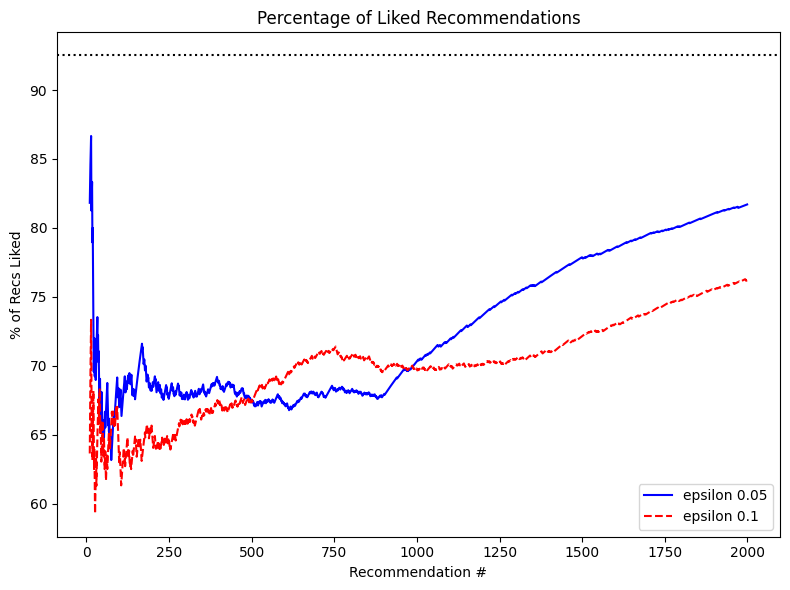

In [74]:
class Evaluator():
    def __init__(self, eps_arr, itr_arr, rec_arr, df_train, df_test) -> None:
        self.eps_arr = eps_arr
        self.itr_arr = itr_arr
        self.rec_arr = rec_arr
        
        self.df_train = df_train
        self.df_test =  df_test
        
        self.eps_scenarios = []
        for j in range(len(self.eps_arr)):
            self.eps_scenarios.append(
                Epsilon_Scenario(
                    epsilon=self.eps_arr[j],
                    df=self.df_train, 
                    recommendations=self.rec_arr[j],
                    iterations=self.itr_arr[j]
                    )
                )
                
         
    def replay_all(self):
        for E in self.eps_scenarios:
            E.run_experiment()
            E.get_best_items()
            E.get_top_10()
            
    def show_comparative_plot(self):
        fig, ax = plt.subplots(figsize=(8,6))

        OFFSET = 10  # NOTE: offset of 10 elements to not start at 1 peak
        # for (avg_results_df, style, label) in [(self.log_df_mean[OFFSET:], 'g-', "epsilon 0.10"), 
        #                                 (self.log_df_mean[OFFSET:], 'r--', "epsilon 0.05"),
        #                                 ]:
        
        line_styles = ['b-','r--','g-.', 'c:', 'm-', 'y--']
        
        for e_idx, E in enumerate(self.eps_scenarios):
            (avg_results_df, style, label) = E.log_df_mean[OFFSET:], line_styles[e_idx], "epsilon "+str(E.epsilon)
        
            ax.plot(avg_results_df.recomendation, avg_results_df.like_fraction, style, linewidth=1.5, label=label)

        ax.axhline(y=E.objective_best_ratio, color='k', linestyle=':', linewidth=1.5)

        ax.set_title('Percentage of Liked Recommendations')
        ax.set_xlabel('Recommendation #')
        ax.set_ylabel('% of Recs Liked')

        # ax.set_xticks(range(0,22000,5000))
        # ax.set_ylim(0.2, 0.6)
        # ax.set_yticks(np.arange(0.2, 0.7, 0.1))

        # rescale the y-axis tick labels to show them as a percentage
        ax.set_yticklabels((ax.get_yticks()*100).astype(int))

        ax.legend(
                loc='lower right'
                )

        plt.tight_layout()
        plt.show()
        
            
TEST_PATH = 'data/test.csv'
df_test = pd.read_csv(TEST_PATH)

DEV = True
if DEV :
    eps_arr = [0.05, 0.1] #, 0.25, 0.5, 0.75]
    rec_arr = [2000 for _ in eps_arr]
    itr_arr = [1 for _ in eps_arr]
else:
    eps_arr = [0.05, 0.1, 0.25, 0.5, 0.75]
    rec_arr = [6000 for _ in eps_arr]
    itr_arr = [1 for _ in eps_arr]

EVAL = Evaluator(eps_arr, itr_arr, rec_arr, df, df_test)
EVAL.replay_all()
EVAL.show_comparative_plot()

In [71]:
EVAL.eps_scenarios[0].log_df_mean.head()

,recomendation,iteration,item_id,user_id,exploration,reward,total_reward,like_fraction
0,0,0.0,194.0,763.0,1.0,1.0,1.0,1.0
1,1,0.0,222.0,407.0,1.0,1.0,2.0,1.0
2,2,0.0,64.0,250.0,1.0,1.0,3.0,1.0
3,3,0.0,69.0,249.0,1.0,1.0,4.0,1.0
4,4,0.0,257.0,880.0,1.0,1.0,5.0,1.0


      recomendation  iteration  item_id  user_id  exploration  reward  \
0                 0        0.0     11.0     99.0          1.0     1.0   
1                 1        0.0    191.0    919.0          1.0     1.0   
2                 2        0.0    194.0    567.0          1.0     0.0   
3                 3        0.0    168.0    293.0          1.0     1.0   
4                 4        0.0    204.0    545.0          1.0     1.0   
...             ...        ...      ...      ...          ...     ...   
1995           1995        0.0     98.0    327.0          0.0     1.0   
1996           1996        0.0     98.0    367.0          0.0     1.0   
1997           1997        0.0     98.0    903.0          0.0     1.0   
1998           1998        0.0     98.0     81.0          0.0     1.0   
1999           1999        0.0     98.0    178.0          0.0     1.0   

      total_reward  like_fraction  
0              1.0       1.000000  
1              2.0       1.000000  
2              

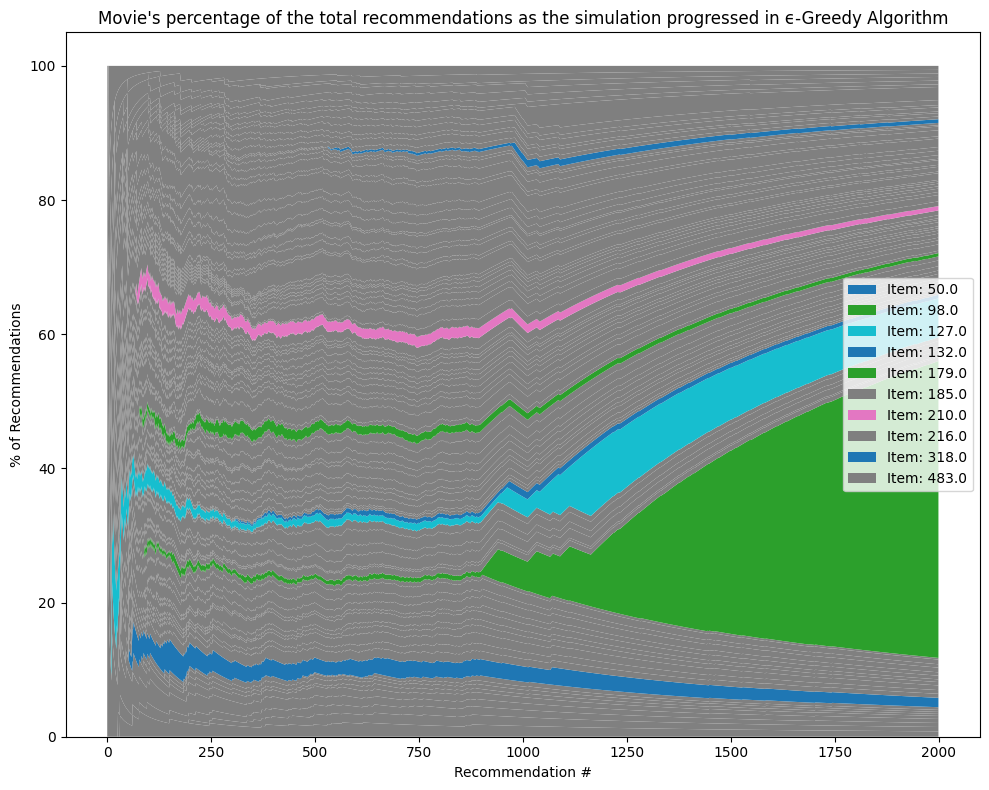

In [ ]:
for E in EVAL.eps_scenarios:

    print(E.log_df_mean)
    # Create a dataframe with running totals of how many times each recommendation was taken
    running_ttl = E.log_df_mean.query('iteration == 0') \
                                    .assign(selected=1) \
                                    .pivot(index='recomendation', columns='item_id', values='selected') \
                                    .fillna(0) \
                                    .cumsum(axis=0) \
                                    .reset_index()
                                    
    item_ids = running_ttl.columns[1:]
    
    
    print(running_ttl)
    
    # # scale the value by the visit number to get turn the running total into a percentage
    running_ttl.iloc[:,1:] = running_ttl.iloc[:,1:].div((running_ttl.recomendation + 1)/100, axis=0)
    
    print(running_ttl) # empty?!?
    
    fig, ax = plt.subplots(figsize=(10,8))

    _top_items = E.top_10
    _top = len(_top_items)
     
    # color_map = {item_id: f'C{i}' for i, item_id in enumerate(item_ids, start=1)}
    color_map = {item_id: sns.color_palette("pastel") for item_id in _top_items}
    print(color_map)
    
    ax.stackplot(running_ttl.recomendation,
                running_ttl.iloc[:,1:20*_top].T,
                labels= ["Item: " + str(x) if x in _top_items else None for x in running_ttl.iloc[:,1:].columns.values],
                # ["Item: " + str(x)  for x in running_ttl.iloc[:,1:_top].columns.values] 
                # + [None for y in running_ttl.iloc[:,_top:].columns.values],
                colors= [color_map[x] if x in _top_items else 'gray' for x in running_ttl.iloc[:,1:].columns.values]
                # [color_map[x] for x in running_ttl.iloc[:,1:_top].columns.values] 
                # + ['gray' for y in running_ttl.iloc[:,_top:].columns.values]
                )


    # ax.set_xlim(0,1000)
    # ax.set_xticks(range(0, 1100, 250))
    # ax.set_xticks(range(0, 20000+1, 2000))

    ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed in ϵ-Greedy Algorithm')
    ax.set_xlabel('Recommendation #')
    ax.set_ylabel('% of Recommendations')

    lgd = plt.legend()
    # lgd = plt.legend(loc='upper left', borderaxespad=0., labelspacing=-2.3)
    # lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), loc=2, borderaxespad=0., labelspacing=-2.3)

    ax.set_facecolor('w')

    plt.tight_layout()
    plt.show()
    
    break


In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.stackplot(ab_1k_running_ttl.visit,
             ab_1k_running_ttl.iloc[:,1:11].T,
             labels=[movie_names[x] for x in ab_1k_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in ab_1k_running_ttl.iloc[:,1:].columns.values]
            )

# ax.set_xlim(0,1000)
ax.set_xticks(range(0, 20000+1, 2000))

ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed in A/B Testing Algorithm')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), loc=2, borderaxespad=0., labelspacing=-2.3)

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [ ]:
sns.barplot(x=np.arange(len(_item_hit_counter)), y=_item_hit_counter)
plt.title(f'Item Hit Counter (epsilon = %.2f)' % epsilon)
plt.xlabel('Item Index')
plt.ylabel('Hit Count')
top_5_indices = np.argsort(_item_hit_counter)[-5:]  # gives indices that would belong to the top 5 values
top_5_labels = {i: str(df_epsilon_05_results["item_id"].iloc[i]) for i in top_5_indices}

plt.xticks(ticks=np.arange(len(_item_hit_counter)), labels=[top_5_labels.get(i, '') for i in range(len(_item_hit_counter))], rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(df_epsilon_05_results['recomendation'], df_epsilon_05_results['item_id'], alpha=0.5, c='blue', s=10)
plt.title(f'Item Usage Over Recommendations (epsilon = %.2f)' % epsilon)
plt.xlabel('Recommendation Number')
plt.ylabel('Item ID')
plt.grid(True)
plt.show()

In [ ]:
_avg_window = 100 

sns.lineplot(data=pd.DataFrame(_tuple_tries).rolling(_avg_window).mean())
plt.title(f'Rolling Average of _tuple_tries (epsilon = %.2f)' % epsilon)
plt.xlabel('Replay Round Number')
plt.ylabel('Rolling Average')
plt.legend(["Window: "+str(_avg_window)])
plt.show()

In [ ]:
n_recommendations = 5000
n_iterations = 5

MAB-training using our replay machine: 

In [ ]:
epsilon = 0.05

epsilon_05_results, df_05_reward_results = EpsilonTrainer(
    epsilon=epsilon,
    reward_database=df,
    item_col_name="item_id",
    user_col_name="user_id",
    reward_col_name="liked",
    n_recommendations=n_recommendations,
    n_iterations=n_iterations 
).replay()

df_epsilon_05_results = pd.DataFrame(epsilon_05_results)

In [ ]:
epsilon = 0.10

epsilon_10_results, df_10_reward_results = EpsilonTrainer(
    epsilon=epsilon,
    reward_database=df,
    item_col_name="item_id",
    user_col_name="user_id",
    reward_col_name="liked",
    n_recommendations=n_recommendations,
    n_iterations=n_iterations 
).replay()

df_epsilon_10_results = pd.DataFrame(epsilon_10_results)

In [ ]:

df_epsilon_05_results_mean = df_epsilon_05_results.groupby('recomendation', as_index=False).mean()

df_epsilon_10_results_mean = df_epsilon_10_results.groupby('recomendation', as_index=False).mean()

## Evaluation

In [ ]:
print(df.head())

In [ ]:
# finding the most liked movie (in percentage)
df_counted_per_item = df["item_id"].value_counts().reset_index()
print(df_counted_per_item.head())
_max = max(df_counted_per_item["count"])
print("Max value is ", _max)

# Calculate the threshold for the top 25%
threshold = df_counted_per_item.quantile(0.75).iloc[0]
print("Threshold is ", threshold)

# Filter DataFrame to get only rows with values in the top 25%
top_25_percent_df = df_counted_per_item[df_counted_per_item["count"] >= threshold]

print("# df:", len(df_counted_per_item), ";  # df.75:", len(top_25_percent_df))


# -- . -- . -- . -- . -- . -- . -- . --

# top_25_items = top_25_percent_df.
top_25_percent_df

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

for (avg_results_df, style, label) in [(df_epsilon_10_results_mean[10:], 'g-', "epsilon 0.10"), # NOTE: offset of 10 elements to not start at 1 peak
                                (df_epsilon_05_results_mean[10:], 'r--', "epsilon 0.05"),
                                ]:
    
    ax.plot(avg_results_df.recomendation, avg_results_df.like_fraction, style, linewidth=1.5, label=label)

# ax.axhline(y=0.85, color='k', linestyle=':', linewidth=1.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

# ax.set_xticks(range(0,22000,5000))
# ax.set_ylim(0.2, 0.6)
# ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(
          loc='lower right'
         )

plt.tight_layout()
plt.show()

In [ ]:
df_epsilon_05_results_mean

In [ ]:
def get_top_5(_df) :
    return _df.sort_values(
                by="X_ratio",
                ascending=False
            ).item_id[0:5].to_list()
    
print(get_top_5(df_epsilon_05_results_mean))
print(get_top_5(df_epsilon_10_results_mean))


In [ ]:
df_reward_results.sort_values(by="X_ratio", ascending=False)

In [ ]:
print(df_epsilon_05_results)

In [ ]:
sns.lineplot(df_epsilon_05_results['like_fraction'])

In [ ]:
#SRC W6
# Create a dataframe with running totals of how many times each recommendation was taken
running_ttl = df_epsilon_05_results.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='recomendation', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()
                                
running_ttl                

In [ ]:
# Create a dictionary to map item IDs to colors
item_ids = running_ttl.columns[1:]
color_map = {item_id: f'C{i}' for i, item_id in enumerate(item_ids, start=1)}
color_map

In [ ]:
# scale the value by the visit number to get turn the running total into a percentage
running_ttl.iloc[:,1:] = running_ttl.iloc[:,1:].div((running_ttl.recomendation + 1)/100, axis=0)


In [ ]:
#SRC W6
 
fig, ax = plt.subplots(figsize=(10,8))

ax.stackplot(running_ttl.recomendation,
             running_ttl.iloc[:,1:100].T,
             labels=[x for x in running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in running_ttl.iloc[:,1:].columns.values],
             lw=0.5, edgecolor='black'
            )

ax.set_xlim(0,1000)
ax.set_xticks(range(0, 1100, 250))
# ax.set_xticks(range(0, 20000+1, 2000))

ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed in ϵ-Greedy Algorithm')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), loc=2, borderaxespad=0., labelspacing=-2.3)
plt.legend(loc='best')

ax.set_facecolor('w')

plt.tight_layout()
plt.show()


In [ ]:
print(df_epsilon_05_results[4:])
df_epsilon_05_results